Cerinta: 
    - Specificaţi,
    - proiectaţi, 
    - implementaţi si 
    - testati 
    cate un algoritm de clasificare bazat pe retele neuronale artificiale (ANN sau CNN).
    - Verificati influenta (hyper)parametrilor asupra calitatii clasificatorului antrenat.



Evaluarea

Punctajele acordate:

creare baza de date - 50p
antrenarea unui model si testarea lui pentru clasificarea imaginilor normale vs sepia
cu ANN (tool) - 50p
influenta (hyper)parametrilor - 100p
cu ANN (cod propriu) - 300p
cu CNN (cod propriu) - 300p


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler


In [2]:
def loadImageData(folder_path):
    image_files = os.listdir(folder_path)
    inputs = []
    outputs = []
    
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        if not image_path == "Data/.DS_Store" :
            image = Image.open(image_path)
            common_size = (100,100) 
            image= image.resize(common_size) 
            image = image.convert("RGB")
            image_array = np.array(image)
            
            if "Sepia" in image_file:
                label = "Sepia"
            elif "Photo" in image_file:
                label = "Photo"
                
            inputs.append(image_array)
            outputs.append(label)
    
    return inputs, outputs

inputs, outputs = loadImageData("Data")
print(inputs[0])
print(outputs[:5])


[[[230 206 160]
  [227 203 158]
  [225 201 155]
  ...
  [156 139 109]
  [155 138 108]
  [153 137 106]]

 [[228 204 158]
  [223 199 155]
  [219 195 152]
  ...
  [161 142 110]
  [160 142 110]
  [158 141 109]]

 [[227 202 157]
  [218 195 151]
  [212 189 147]
  ...
  [163 144 112]
  [163 144 112]
  [162 144 111]]

 ...

 [[230 203 158]
  [232 205 160]
  [246 220 171]
  ...
  [199 177 138]
  [199 177 138]
  [199 177 138]]

 [[228 203 157]
  [237 209 163]
  [246 225 175]
  ...
  [201 179 138]
  [200 178 138]
  [200 178 138]]

 [[229 204 159]
  [236 209 162]
  [252 239 188]
  ...
  [201 179 138]
  [201 179 139]
  [200 178 138]]]
['Sepia', 'Sepia', 'Sepia', 'Sepia', 'Photo']


In [3]:
def splitData(inputs, outputs):
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    testSample = [i for i in indexes  if not i in trainSample]

    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]
    
    return trainInputs, trainOutputs, testInputs, testOutputs

In [4]:
def normalisation(trainData, testData):
    scaler = StandardScaler()
    if not isinstance(trainData[0], list):
        #encode each sample into a list
        trainData = [d for d in trainData]
        testData = [d for d in testData]
        
        scaler.fit(trainData)  #  fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data
        
        #decode from list to raw values
        normalisedTrainData = [el[0] for el in normalisedTrainData]
        normalisedTestData = [el[0] for el in normalisedTestData]
    else:
        scaler.fit(trainData)  #  fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data
    return normalisedTrainData, normalisedTestData

In [5]:
def flatten(mat):
    x = []
    for line in mat:
        for el in line:
            x.append(el)
    return x 


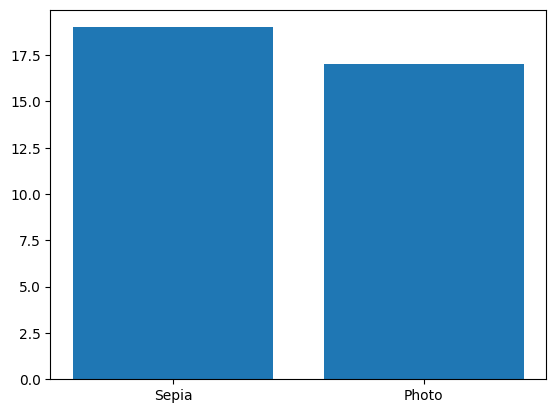

In [6]:
trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)

bins = range(3)
plt.hist(trainOutputs, bins, rwidth = 0.8)
bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), ["Sepia", "Photo"])
plt.show()

In [7]:
trainInputsFlatten = [np.array(image).flatten() for image in trainInputs]
testInputsFlatten = [np.array(image).flatten() for image in testInputs]

In [8]:
def calculatePerformance(true_labels, predicted_labels):
    print("true labels: " , true_labels)
    print("predicted labels: ", predicted_labels)
    true_labels = [1 if el == "Sepia" else 0 for el in true_labels]
    predicted_labels = [1 if el == "Sepia" else 0 for el in predicted_labels]
    
    # Calcularea matricei de confuzie
    tp = 0  # True Positive
    fp = 0  # False Positive
    fn = 0  # False Negative
    tn = 0  # True Negative
    
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        if true_label == 1 and predicted_label == 1:
            tp += 1
        elif true_label == 0 and predicted_label == 1:
            fp += 1
        elif true_label == 1 and predicted_label == 0:
            fn += 1
        elif true_label == 0 and predicted_label == 0:
            tn += 1
    
    # Calcularea metricilor de performanță
    print(tp)
    print(fp)
    print(tn)
    print(fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0
    confusion_matrix = [[tn, fp], [fn, tp]]
    
    return precision, recall, accuracy, confusion_matrix




In [9]:
def plotConfusionMatrix(cm, classNames, title):
    from sklearn.metrics import confusion_matrix
    import itertools 

    classes = classNames
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = 'Blues')
    plt.title('Confusion Matrix ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    text_format = 'd'
    thresh = cm.max() / 2.
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], text_format),
                horizontalalignment = 'center',
                color = 'white' if cm[row, column] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

Iteration 1, loss = 18.40930970
Iteration 2, loss = 17.02063021
Iteration 3, loss = 6.85534983
Iteration 4, loss = 1.21387084
Iteration 5, loss = 0.94070457
Iteration 6, loss = 0.78017411
Iteration 7, loss = 0.75504936
Iteration 8, loss = 0.73873233
Iteration 9, loss = 0.73229549
Iteration 10, loss = 0.73229539
Iteration 11, loss = 0.73229528
Iteration 12, loss = 0.73229516
Iteration 13, loss = 0.73229503
Iteration 14, loss = 0.73229490
Iteration 15, loss = 0.73229476
Iteration 16, loss = 0.73229462
Iteration 17, loss = 0.73229447
Iteration 18, loss = 0.73229432
Iteration 19, loss = 0.73229416
Iteration 20, loss = 0.73229400
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
true labels:  ['Sepia' 'Sepia' 'Photo' 'Sepia' 'Photo' 'Sepia' 'Photo' 'Photo' 'Sepia'
 'Photo']
predicted labels:  ['Sepia' 'Sepia' 'Sepia' 'Sepia' 'Sepia' 'Sepia' 'Sepia' 'Sepia' 'Sepia'
 'Sepia']
5
5
0
0


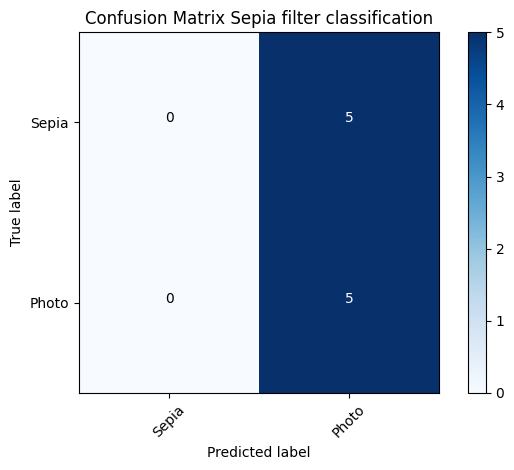

acc:  0.5
precision:  1.0
recall:  0.5


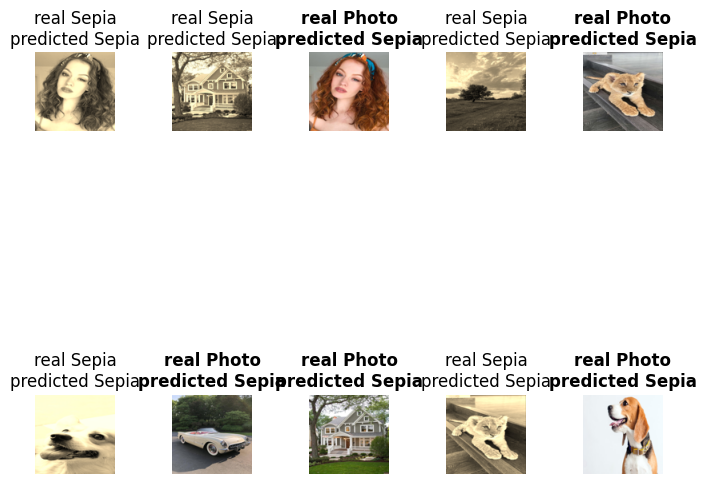

In [10]:
from sklearn import neural_network

classifier = neural_network.MLPClassifier(hidden_layer_sizes=(5, ), activation='relu', max_iter=1000, solver='sgd', verbose=10, random_state=1, learning_rate_init=0.000001)

# training(classifier, trainInputsNormalised, trainOutputs)
classifier.fit(trainInputsFlatten, trainOutputs)

predictedLabels = classifier.predict(testInputsFlatten)


acc, prec, recall, cm = calculatePerformance(np.array(testOutputs), predictedLabels)
cm = np.array(cm)
plotConfusionMatrix(cm, ["Sepia", "Photo"], "Sepia filter classification")
print('acc: ', acc)
print('precision: ', prec)
print('recall: ', recall)

# plot first 50 test images and their real and computed labels
n = 2
m = 5
fig, axes = plt.subplots(n, m, figsize = (7, 7))
fig.tight_layout() 
for i in range(0, n):
    for j in range(0, m):
        axes[i][j].imshow(testInputs[m * i + j])
        if (testOutputs[m * i + j] == predictedLabels[m * i + j]):
            font = 'normal'
        else:
            font = 'bold'
        axes[i][j].set_title('real ' + str(testOutputs[m * i + j]) + '\npredicted ' + str(predictedLabels[m * i + j]), fontweight=font)
        axes[i][j].set_axis_off()

plt.show()

In [26]:
import math

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Inițializarea parametrilor rețelei neuronale
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_input_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_hidden_output = np.zeros((1, output_size))
        
    def relu(self, x):
        return [max(0, val) for val in x]

    def relu_derivative(self, x):
        # Derivata funcției de activare ReLU
        return [1 if val > 0 else 0 for val in x]
    
    def softmax(self, x):
        # Funcția de activare Softmax pentru ultimul strat
        exp_scores = [math.exp(val - max(x)) for val in x]
        exp_sum = sum(exp_scores)
        return [exp_val / exp_sum for exp_val in exp_scores]

    def dot_product(self, X, Y):
        # Produsul scalar între X și Y
        return [[sum(a * b for a, b in zip(X_row, Y_col)) for Y_col in zip(*Y)] for X_row in X]

    def sum(self, X, axis=None, keepdims=False):
        # Suma elementelor din X
        if axis is None:
            return np.sum(X)
        elif axis == 0:
            return [sum(col) for col in zip(*X)]
        elif axis == 1:
            return [sum(row) for row in X]

    def forward(self, X):
        # Propagarea înainte a datelor prin rețea
        hidden_input = self.dot_product(X, self.weights_input_hidden) + self.bias_input_hidden
        hidden_output = self.relu(hidden_input)
        output_input = self.dot_product(hidden_output, self.weights_hidden_output) + self.bias_hidden_output
        output = self.softmax(output_input)
        return output

    def backward(self, X, y, output, learning_rate):
        hidden_input = self.dot_product(X, self.weights_input_hidden) + self.bias_input_hidden
        hidden_output = self.relu(hidden_input)
        # Propagarea înapoi a erorii și actualizarea parametrilor
        m = len(X)
        grad_output_input = [[output[i][j] - y[i][j] for j in range(len(output[i]))] for i in range(len(output))]

        grad_weights_hidden_output = self.dot_product(np.transpose(hidden_output), grad_output_input) / m
        grad_bias_hidden_output = self.sum(grad_weights_hidden_output, axis=0, keepdims=True) / m
        grad_hidden_output = self.dot_product(grad_output_input, np.transpose(self.weights_hidden_output))
        grad_hidden_input = [[grad_hidden_output[i][j] * self.relu_derivative(hidden_input[i][j]) for j in range(len(hidden_input[i]))] for i in range(len(hidden_input))]
        grad_weights_input_hidden = self.dot_product(np.transpose(X), grad_hidden_input) / m
        grad_bias_input_hidden = self.sum(grad_hidden_input, axis=0, keepdims=True) / m

        # Actualizarea parametrilor
        self.weights_input_hidden -= learning_rate * grad_weights_input_hidden
        self.bias_input_hidden -= learning_rate * grad_bias_input_hidden
        self.weights_hidden_output -= learning_rate * grad_weights_hidden_output
        self.bias_hidden_output -= learning_rate * grad_bias_hidden_output



    def train(self, X, y, learning_rate, num_epochs):
        # Antrenarea rețelei neuronale
        for epoch in range(num_epochs):
            # Propagarea înainte
            output = self.forward(X)
            # Propagarea înapoi și actualizarea parametrilor
            self.backward(X, y, output, learning_rate)
            # Calculul costului (funcția de pierdere cross-entropy)
            loss = self.cross_entropy_loss(output, y)
            # Afișarea costului la fiecare 100 de epoci
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        # Prezicerea claselor pentru datele de intrare X
        output = self.forward(X)
        max_indices = []
        for row in output:
            max_index = max(range(len(row)), key=lambda i: row[i])
            max_indices.append(max_index)
        return max_indices

    def cross_entropy_loss(self, output, y):
        # Calculul funcției de pierdere cross-entropy
        m = len(y)
        log_probs = [-math.log(output[i][y[i]]) for i in range(m)]
        loss = sum(log_probs) / m
        return loss

Epoch 0, Loss: 0.6931472173789507
Epoch 100, Loss: 0.6920085173223529
Epoch 200, Loss: 0.6908716921021001
Epoch 300, Loss: 0.6897379459744353
Epoch 400, Loss: 0.6886071889747366
Epoch 500, Loss: 0.687479333266985
Epoch 600, Loss: 0.6863542931212129
Epoch 700, Loss: 0.6852319848925601
Epoch 800, Loss: 0.6841123270018927
Epoch 900, Loss: 0.6829952399179573
true labels:  ['Sepia' 'Sepia' 'Photo' 'Sepia' 'Photo' 'Sepia' 'Photo' 'Photo' 'Sepia'
 'Photo']
predicted labels:  ['Sepia', 'Sepia', 'Sepia', 'Sepia', 'Sepia', 'Sepia', 'Sepia', 'Sepia', 'Sepia', 'Sepia']
5
5
0
0


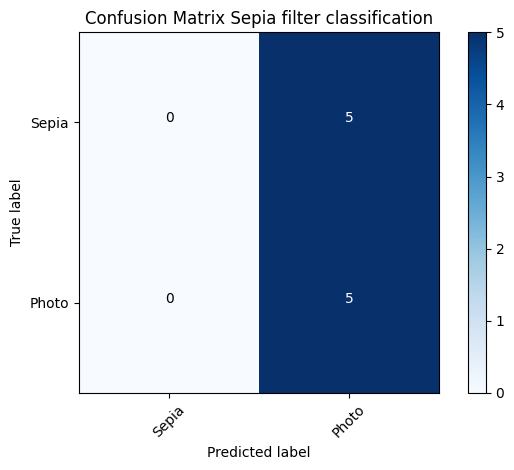

acc:  0.5
precision:  1.0
recall:  0.5


In [25]:
trainOutputs = [1 if el == "Sepia" else 0 for el in trainOutputs]

trainInputsFlatten = [el/255 for el in trainInputsFlatten]
classifier = NeuralNetwork(30000, 10, 2)

# training(classifier, trainInputsNormalised, trainOutputs)
classifier.train(np.array(trainInputsFlatten), np.array(trainOutputs), 0.005, 1000)

predictedLabels = classifier.predict(testInputsFlatten)
predictedLabels = ["Sepia" if el == 1 else "Photo" for el in predictedLabels ]

acc, prec, recall, cm = calculatePerformance(np.array(testOutputs), predictedLabels)
cm = np.array(cm)
plotConfusionMatrix(cm, ["Sepia", "Photo"], "Sepia filter classification")
print('acc: ', acc)
print('precision: ', prec)
print('recall: ', recall)

# # plot first 50 test images and their real and computed labels
# n = 2
# m = 5
# fig, axes = plt.subplots(n, m, figsize=(7, 7))
# fig.tight_layout()
# for i in range(0, n):
#     for j in range(0, m):
#         axes[i][j].imshow(testInputs[m * i + j])
#         if (testOutputs[m * i + j] == predictedLabels[m * i + j]):
#             font = 'normal'
#         else:
#             font = 'bold'
#         axes[i][j].set_title('real ' + str(testOutputs[m * i + j]) + '\npredicted ' + str(predictedLabels[m * i + j]),
#                              fontweight=font)
#         axes[i][j].set_axis_off()
# 
# plt.show()

In [15]:
import numpy as np

class CNN:
    def __init__(self, layers_dims):
        self.layers_dims = layers_dims
        self.parameters = self.initialize_parameters()

    def initialize_parameters(self):
        parameters = {}
        L = len(self.layers_dims)
        
        for l in range(1, L):
            parameters[f"W{l}"] = np.random.randn(self.layers_dims[l][0], self.layers_dims[l][1], self.layers_dims[l][2], self.layers_dims[l-1][0]) * 0.01
            parameters[f"b{l}"] = np.zeros((self.layers_dims[l][0], 1))
        
        return parameters

    def conv_forward(self, X, W, b, stride=1, padding=0):
        (n_H_prev, n_W_prev, n_C_prev) = X.shape
        (f, f, n_C_prev, n_C) = W.shape
        n_H = int((n_H_prev - f + 2 * padding) / stride) + 1
        n_W = int((n_W_prev - f + 2 * padding) / stride) + 1
        Z = np.zeros((n_H, n_W, n_C))
        
        if padding > 0:
            X_pad = np.pad(X, ((padding, padding), (padding, padding), (0, 0)), mode='constant', constant_values=0)
        else:
            X_pad = X
        
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice_prev = X_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    Z[h, w, c] = np.sum(a_slice_prev * W[:, :, :, c]) + b[c]
                    
        return Z

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        exp_Z = np.exp(Z)
        return exp_Z / np.sum(exp_Z, axis=-1, keepdims=True)

    def conv_backward(self, dZ, cache):
        (X, W, b, stride, padding) = cache
        (n_H_prev, n_W_prev, n_C_prev) = X.shape
        (f, f, n_C_prev, n_C) = W.shape
        (n_H, n_W, n_C) = dZ.shape
        dX = np.zeros(X.shape)
        dW = np.zeros(W.shape)
        db = np.zeros(b.shape)
        
        if padding > 0:
            X_pad = np.pad(X, ((padding, padding), (padding, padding), (0, 0)), mode='constant', constant_values=0)
            dX_pad = np.pad(dX, ((padding, padding), (padding, padding), (0, 0)), mode='constant', constant_values=0)
        else:
            X_pad = X
            dX_pad = dX
        
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice_prev = X_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    dW[:, :, :, c] += a_slice_prev * dZ[h, w, c]
                    db[c] += dZ[h, w, c]
                    dX_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[h, w, c]
        
        if padding > 0:
            dX = dX_pad[padding:-padding, padding:-padding, :]
        else:
            dX = dX_pad
        
        return dX, dW, db

    def forward_propagation(self, X):
        caches = []
        A_prev = X
        
        for l in range(1, len(self.layers_dims)):
            W = self.parameters[f"W{l}"]
            b = self.parameters[f"b{l}"]
            Z = self.conv_forward(A_prev, W, b)
            A = self.relu(Z)
            cache = (A_prev, W, b, Z)
            caches.append(cache)
            A_prev = A
        
        return A, caches

    def compute_cost(self, AL, Y):
        m = Y.shape[1]
        cost = -1/m * np.sum(Y * np.log(AL))
        cost = np.squeeze(cost)
        return cost

    def backward_propagation(self, AL, Y, caches):
        grads = {}
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        current_cache = caches[-1]
        dZ = dAL * self.relu_backward(current_cache[3])
        grads[f"dA{len(caches)}"], grads[f"dW{len(caches)}"], grads[f"db{len(caches)}"] = self.conv_backward(dZ, current_cache)
        
        for l in reversed(range(len(caches)-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.conv_backward(grads[f"dA{l+2}"], current_cache)
            grads[f"dA{l+1}"] = dA_prev_temp
            grads[f"dW{l+1}"] = dW_temp
            grads[f"db{l+1}"] = db_temp
        
        return grads

    def update_parameters(self, grads, learning_rate):
        L = len(self.layers_dims)
        
        for l in range(1, L):
            self.parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
            self.parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]

    def train(self, X, Y, learning_rate=0.01, num_iterations=1000):
        for i in range(num_iterations):
            AL, caches = self.forward_propagation(X)
            cost = self.compute_cost(AL, Y)
            grads = self.backward_propagation(AL, Y, caches)
            self.update_parameters(grads, learning_rate)
            
            if i % 100 == 0:
                print(f"Iteration {i}, Cost: {cost}")

    def predict(self, X):
        AL, _ = self.forward_propagation(X)
        predictions = np.argmax(AL, axis=1)
        return predictions


In [16]:
rainOutputs = [1 if el == "Sepia" else 0 for el in trainOutputs]

trainInputsFlatten = [el/255 for el in trainInputsFlatten]
classifier = CNN([4])

# training(classifier, trainInputsNormalised, trainOutputs)
classifier.train(np.array(trainInputsFlatten), np.array(trainOutputs))

predictedLabels = classifier.predict(testInputsFlatten)
predictedLabels = ["Sepia" if el == 1 else "Photo" for el in predictedLabels ]

acc, prec, recall, cm = calculatePerformance(np.array(testOutputs), predictedLabels)
cm = np.array(cm)
plotConfusionMatrix(cm, ["Sepia", "Photo"], "Sepia filter classification")
print('acc: ', acc)
print('precision: ', prec)
print('recall: ', recall)

UnboundLocalError: local variable 'A' referenced before assignment